In [1]:
import json
import multiprocessing
import os
import pickle
import warnings
from collections import defaultdict
from multiprocessing import Manager, Pool
from multiprocessing.managers import SyncManager
from operator import attrgetter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import open3d
import torch
from PIL import Image
from scipy.spatial.transform import Rotation as R
from sklearn.decomposition import PCA
from torch import nn
from torch.nn import Conv2d
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

import utils
from benchmark_utils import pose_utils
from UNet import Unet

from skimage.transform import rescale
from skimage.transform import resize



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
testing_data_dir = "./data/testing_data_pose/testing_data_pose_filtered/testing_data/v2.2"
split_dir = "./data/training_data/training_data_filtered/training_data/splits/v2"
training_data_dir = "./data/training_data/training_data_filtered/training_data/v2.2"


In [3]:
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def display_3d(points_viewer):
    points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
    pcd = open3d.geometry.PointCloud()
    pcd.points = points
    pcd.colors = colors
    open3d.visualization.draw_geometries([pcd])

def get_split_files(training_data_dir,split_dir,split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

def np2o3d(points_viewer):
    # points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    # colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
    points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    pcd = open3d.geometry.PointCloud()
    pcd.points = points
    # pcd.colors = colors
    return pcd

def draw_bb(poses_world,meta,rgb):
    box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
    boxed_image = np.array(rgb)
    for i in range(len(poses_world)):
        utils.draw_projected_box3d(
            boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
            thickness=2)
    # plt.plot(Image.fromarray((boxed_image * 255).astype(np.uint8)))
    return(Image.fromarray((boxed_image * 255).astype(np.uint8)))

def point_cloud_image_in_c(meta,depth):
    intrinsic = meta['intrinsic']
    z = depth
    v, u = np.indices(z.shape)
    uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
    points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
    return(points_viewer)

def align_rotation_matrix(vec1, vec2):
    """get rotation matrix between two vectors using scipy
    vec1->source
    vec2->target
    """
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    r = R.align_vectors(vec2, vec1)
    return r[0].as_matrix()

def rot_align_via_PCA(src,tgt):
    try:
        pca = PCA(n_components=3)
        pca.fit(src)
        eig_vec = pca.components_
        normal_src = eig_vec[2, :] 
        pca = PCA(n_components=3)
        pca.fit(tgt)
        eig_vec = pca.components_
        normal_tgt = eig_vec[2, :] 
        return(align_rotation_matrix(normal_src, normal_tgt))
    except:
        return(np.eye(3))
    

def get_best_transform(pcd,obj,skip = 64,train_red_factor = 1):
    registrationResults = []
    init_t = np.eye(4)
    for pcd_tr in tqdm(point_cloud_dict[obj][::train_red_factor],leave=False):
        pcd_tr = pcd_tr[::skip]
        # pcd = pcd[::skip]
        shift = (np.mean(pcd,0)-np.mean(pcd_tr,0))
        init_t[:3,3] = shift
        init_t[:3,:3] = rot_align_via_PCA(pcd_tr,pcd)
        tmp = open3d.pipelines.registration.registration_icp(np2o3d(pcd_tr),
                                                             np2o3d(pcd),
                                                     0.2,init_t)        
        registrationResults.append([len(tmp.correspondence_set),tmp.inlier_rmse,tmp.transformation])
    registrationResults = np.array(registrationResults,dtype=object)
    if(not(np.all(registrationResults[:,0]==0))):
        registrationResults = registrationResults[np.squeeze(np.argwhere(registrationResults[:,0]!=0))]
    registrationResults = registrationResults[np.argsort(-registrationResults[:,0])[:len(registrationResults)//5]]
    T = np.copy(registrationResults[np.argmin(registrationResults[:,1])][2])
    # print(T,registrationResults[np.argmin(registrationResults[:,1])],registrationResults)
    # T[:3,3]+=shift
    return(T)


In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, rgb_files,label_files):
        super().__init__()
        self.image_names = rgb_files
        self.label_names = label_files

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        rgb = np.array(Image.open(self.image_names[idx]))
        rgb = rgb[::4,::4]
        img = (
          torch.tensor(rgb / 255.0, dtype=torch.float32)
          .permute(2, 0, 1)
          .contiguous()
        )
        if(not(self.label_names is None)):
            label = np.array(Image.open(self.label_names[idx]))
            label = label[::4,::4]
            lbl = torch.tensor(label, dtype=torch.int64).contiguous()
        else:
            lbl = None
        return {"image": img, "label": lbl}

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_loaded = Unet()
pth_name = "saved_model_2022_12_07T03_56_29.pth"
model_loaded.load_state_dict(torch.load(f'./weights/{pth_name}',map_location=device))

model_loaded.to(device)

Unet(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [6]:
with open("./data/testing_data_pose/testing_data_pose_filtered/testing_data/test.txt",'r') as f:
    prefix = [os.path.join(testing_data_dir, line.strip()) for line in f if line.strip()]
    rgb_test_files = [p + "_color_kinect.png" for p in prefix]
    depth_test_files = [p + "_depth_kinect.png" for p in prefix]
    meta_test_files= [p + "_meta.pkl" for p in prefix]


In [7]:
dataset_test = Dataset(rgb_test_files,None)

In [8]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

In [9]:
model_loaded.eval()
labels_test = []
for i in tqdm(range(len(dataset_test))):
    rgb = dataset_test[i]['image']
    label = np.argmax(np.transpose(np.squeeze(model_loaded(torch.unsqueeze(rgb,0).to(device)).cpu().detach().numpy(),0),(1,2,0)),-1)
    label_ip = resize(label, (720,1280), order = 0,preserve_range=True)
    labels_test.append(label_ip)

  5%|██                                        | 10/200 [00:02<00:54,  3.50it/s]


KeyboardInterrupt: 

In [ ]:
np.array(labels_test).shape

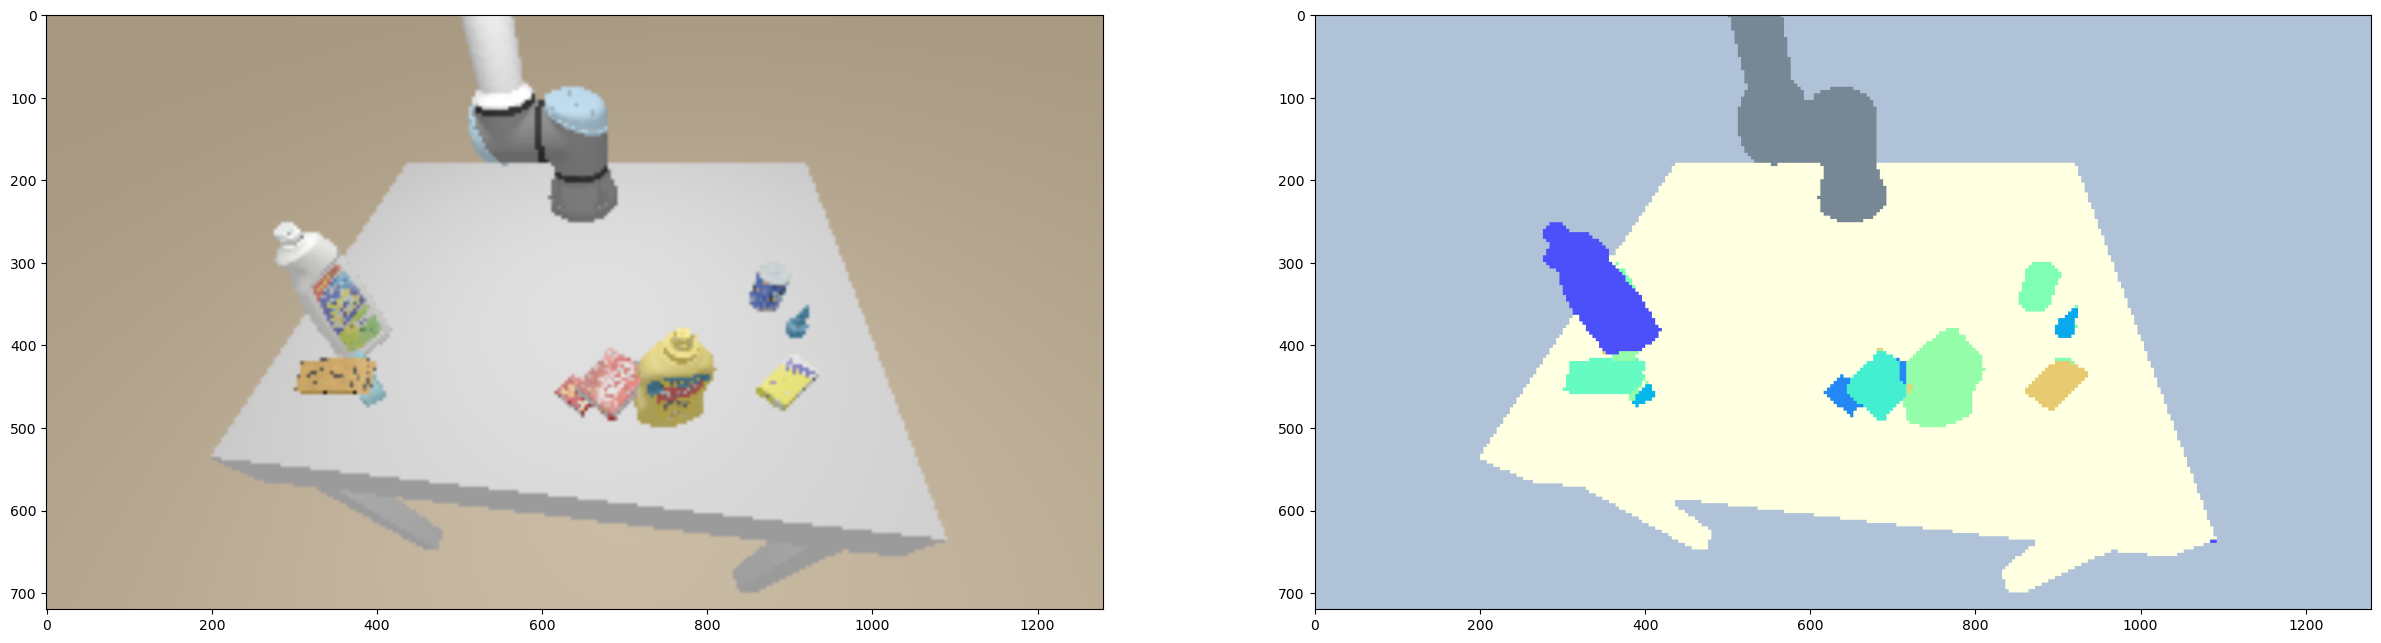

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale
from skimage.transform import resize

rgb = dataset_test[100]['image']

model_loaded.eval()
pred_label = np.argmax(np.transpose(np.squeeze(model_loaded(torch.unsqueeze(rgb,0).to(device)).cpu().detach().numpy(),0),(1,2,0)),-1)
# pred_label = 
# model.eval()
# test_labels = np.argmin(np.transpose(model(torch.tensor(np.transpose(test_images,(0,3,1,2))).float().to(device)).detach().cpu().numpy(),(0,2,3,1)),axis=-1)*255

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(rescale(np.transpose(rgb,(1,2,0)),4,channel_axis=-1))
# plt.subplot(1, 3, 2)
# plt.imshow(COLOR_PALETTE[pred_label])
plt.subplot(1, 2, 2)
plt.imshow(COLOR_PALETTE[resize(pred_label, (720,1280), order = 0,preserve_range=True)])  # draw colorful segmentation

In [11]:
from skimage.transform import resize
resize(pred_label, (720,1280), order = 0,preserve_range=True).shape


(720, 1280)

# Making a Pickle

In [17]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'train')
rgb_files_val, depth_files_val, label_files_val, meta_files_val = get_split_files(training_data_dir,split_dir,'val')


In [19]:
print(len(rgb_files))
rgb_files+=rgb_files_val
print(len(rgb_files))


3964
4200


In [20]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'train')
rgb_files_val, depth_files_val, label_files_val, meta_files_val = get_split_files(training_data_dir,split_dir,'val')
rgb_files+=rgb_files_val;depth_files+=depth_files_val; label_files+=label_files_val; meta_files+=meta_files_val;
point_cloud_dict = defaultdict(list)
for meta_file,depth_file,label_file in tqdm(zip(meta_files,depth_files,label_files),total=len(meta_files)):
    depth = np.array(Image.open(depth_file)) / 1000   # convert from mm to m
    meta = load_pickle(meta_file)
    label = np.array(Image.open(label_file))
    pc_image = point_cloud_image_in_c(meta,depth)
    extrinsic = meta['extrinsic']
    extr_inv = np.linalg.inv(extrinsic)
    # inv_Rext = np.linalg.inv(extrinsic[:3,:3])
    # # inv_Rext = extrinsic[:3,:3].T
    # inv_text = -inv_Rext@extrinsic[:3,3]
    for objind in meta['object_ids']:
        seg_pcd = pc_image[label==objind]
        # seg_pcd_world = (seg_pcd@inv_Rext.T)+inv_text
        # seg_pcd_world = (np.column_stack((seg_pcd,np.ones(seg_pcd.shape[0])))@extr_inv.T)[:,:3]
        # seg_pcd_world = ((np.column_stack((seg_pcd,np.ones(seg_pcd.shape[0]))))@extr_inv)[:,:3]
        seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3]
        
        world_pose = meta['poses_world'][objind]
        # inv_Rpose = np.linalg.inv(world_pose[:3,:3])
        # # inv_Rpose = world_pose[:3,:3].T
        # inv_tpose = np.squeeze(-inv_Rpose@world_pose[:3,3])
        pose_inv = np.linalg.inv(world_pose)
        # seg_pcd_base = (seg_pcd_world@inv_Rpose.T)+inv_tpose
        # seg_pcd_base = ((np.column_stack((seg_pcd_world,np.ones(seg_pcd_world.shape[0]))))@pose_inv.T)[:,:3]
        # seg_pcd_base = (pose_inv@(np.column_stack((seg_pcd_world,np.ones(seg_pcd_world.shape[0]))).T)).T[:,:3]
        seg_pcd_base = seg_pcd_world@ pose_inv[:3, :3].T + pose_inv[:3, 3]
        
        point_cloud_dict[objind].append(seg_pcd_base)
with open('obj_pcd_dict.pickle', 'wb') as handle:
    pickle.dump(point_cloud_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|███████████████████████████████████████| 4200/4200 [05:23<00:00, 12.97it/s]


# Validating Pickle

In [16]:
point_cloud_dict = load_pickle("obj_pcd_dict.pickle")

In [25]:
entire_pcd = np.vstack(point_cloud_dict[list(point_cloud_dict.keys())[4]])
display_3d(entire_pcd[::len(entire_pcd)//50000])

In [22]:
len(entire_pcd)

8501912

# Testing Pcd

In [14]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'train')

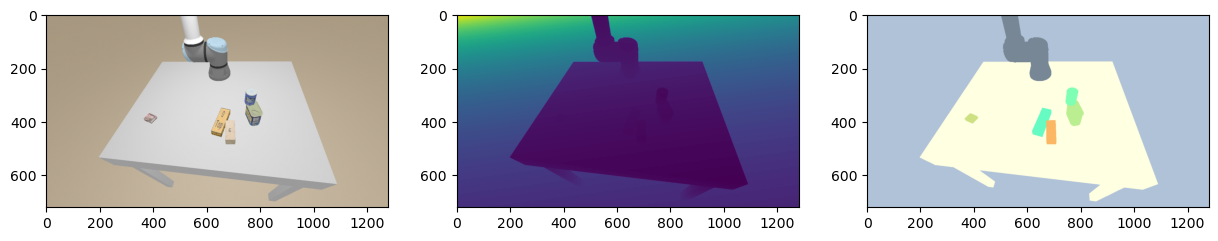

In [15]:
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [16]:
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
meta = load_pickle(meta_files[0])
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
pc_image = point_cloud_image_in_c(meta,depth)
extrinsic = meta['extrinsic']
extr_inv = np.linalg.inv(extrinsic)
for objind in meta['object_ids']:
    seg_pcd = pc_image[label==objind]
    seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3]

    world_pose = meta['poses_world'][objind]
    pose_inv = np.linalg.inv(world_pose)
    seg_pcd_base = seg_pcd_world@ pose_inv[:3, :3].T + pose_inv[:3, 3]
    display_3d(seg_pcd_base)
